<a href="https://colab.research.google.com/github/guyyariv/DL_ex2/blob/master/EX2_DL_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchtext.legacy.data import Field
import torchtext as tx
from torchtext.vocab import GloVe
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
import re
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
import pandas as pd

import torch as tr
import torch
from torch.nn.functional import pad
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_LENGTH = 100
embedding_size = 100
Train_size=30000



def review_clean(text):
    text = re.sub(r'[^A-Za-z]+', ' ', text)  # remove non alphabetic character
    text = re.sub(r'https?:/\/\S+', ' ', text)  # remove links
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)  # remove singale char
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


def tokinize(s):
    s = review_clean(s).lower()
    splited = s.split()
    return splited[:MAX_LENGTH]


def load_data_set(load_my_reviews=False):
    data=pd.read_csv("IMDB Dataset.csv")
    train_data=data[:Train_size]
    train_iter=ReviewDataset(train_data["review"],train_data["sentiment"])
    test_data=data[Train_size:]
    if load_my_reviews:
        my_data = pd.DataFrame({"review": my_test_texts, "sentiment": my_test_labels})
        test_data=test_data.append(my_data)
    test_data=test_data.reset_index(drop=True)
    test_iter=ReviewDataset(test_data["review"],test_data["sentiment"])
    return train_iter, test_iter


embadding = GloVe(name='6B', dim=embedding_size)
tokenizer = get_tokenizer(tokenizer=tokinize)


def preprocess_review(s):
    cleaned = tokinize(s)
    embadded = embadding.get_vecs_by_tokens(cleaned)
    if embadded.shape[0] != 100 or embadded.shape[1] != 100:
        embadded = torch.nn.functional.pad(embadded, (0, 0, 0, MAX_LENGTH - embadded.shape[0]))
    return torch.unsqueeze(embadded, 0)


def preprocess_label(label):
    return [0.0, 1.0] if label == "negative" else [1.0, 0.0]


def collact_batch(batch):
    label_list = []
    review_list = []
    embadding_list=[]
    for  review,label in batch:
        label_list.append(preprocess_label(label))### label
        review_list.append(tokinize(review))### the  actuall review
        processed_review = preprocess_review(review).detach()
        embadding_list.append(processed_review) ### the embedding vectors
    label_list = torch.tensor(label_list, dtype=torch.float32).reshape((-1, 2))
    embadding_tensor= torch.cat(embadding_list)
    return label_list.to(device), embadding_tensor.to(device) ,review_list

In [44]:
##########################
# ADD YOUR OWN TEST TEXT #
##########################

my_test_texts = []
my_test_texts.append(" this movie is very very bad ,the worst movie ")
my_test_texts.append(" this movie is so great")
my_test_texts.append("I really  liked the fish and animations the anther casting was not so good ")
my_test_labels = ["neg", "pos", "pos"]

##########################
##########################


class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, review_list, labels):
        'Initialization'
        self.labels = labels
        self.reviews = review_list

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        X = self.reviews[index]
        y = self.labels[index]
        return X, y



def get_data_set(batch_size, toy=False):
        train_data, test_data = load_data_set(load_my_reviews=toy)
        train_dataloader = DataLoader(train_data, batch_size=batch_size,
                                      shuffle=True, collate_fn=collact_batch)
        test_dataloader = DataLoader(test_data, batch_size=batch_size,
                                     shuffle=True, collate_fn=collact_batch)
        return train_dataloader, test_dataloader, MAX_LENGTH, embedding_size


In [43]:
########################################################################
########################################################################
##                                                                    ##
##                      ORIGINAL _ DO NOT PUBLISH                     ##
##                                                                    ##
########################################################################
########################################################################




batch_size = 32
output_size = 2
hidden_size = 64        # to experiment with

run_recurrent = True    # else run Token-wise MLP
use_RNN = False          # otherwise GRU
atten_size = 0          # atten > 0 means using restricted self atten

reload_model = False
num_epochs = 10
learning_rate = 0.001
test_interval = 50

# Loading sataset, use toy = True for obtaining a smaller dataset

train_dataset, test_dataset, num_words, input_size = get_data_set(batch_size)

# Special matrix multipication layer (like torch.Linear but can operate on arbitrary sized
# tensors and considers its last two indices as the matrix.)

class MatMul(nn.Module):
    def __init__(self, in_channels, out_channels, use_bias = True):
        super(MatMul, self).__init__()
        self.matrix = torch.nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(in_channels,out_channels)), requires_grad=True)
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros(1,1,out_channels), requires_grad=True)

        self.use_bias = use_bias

    def forward(self, x):        
        x = torch.matmul(x,self.matrix) 
        if self.use_bias:
            x = x+ self.bias 
        return x
        


In [47]:


# Implements RNN Unit
class ExRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExRNN, self).__init__()

        self.hidden_size = hidden_size
        self.sigmoid = torch.sigmoid

        # RNN Cell weights
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)
        # what else?

    def name(self):
        return "RNN"

    def forward(self, x, hidden_state):
        combined=torch.cat((x,hidden_state),1)
        hidden=self.sigmoid(self.in2hidden(combined))
        output=self.in2output(combined)
        # Implementation of RNN cell
        
        return output, hidden

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size)

# Implements GRU Unit

class ExGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # reset gate components
        self.linear_reset_w1 = nn.Linear(self.input_size, self.hidden_size, bias=True)
        self.linear_reset_r1 = nn.Linear(self.hidden_size, self.hidden_size, bias=True)

        self.linear_reset_w2 = nn.Linear(self.input_size, self.hidden_size, bias=True)
        self.linear_reset_r2 = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.activation_1 = nn.Sigmoid()

        # update gate components
        self.linear_gate_w3 = nn.Linear(self.input_size, self.hidden_size, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.activation_2 = nn.Sigmoid()

        self.activation_3 = nn.Tanh()
        self.fc=nn.Linear(hidden_size,output_size)

    def name(self):
        return "GRU"

    def reset_gate(self, x, h):
        x_1 = self.linear_reset_w1(x)
        h_1 = self.linear_reset_r1(h)
        # gate update
        reset = self.activation_1(x_1 + h_1)
        return reset

    def update_gate(self, x, h):
        x_2 = self.linear_reset_w2(x)
        h_2 = self.linear_reset_r2(h)
        z = self.activation_2( h_2 + x_2)
        return z

    def update_component(self, x,h,r):
        x_3 = self.linear_gate_w3(x)
        h_3 = r * self.linear_gate_r3(h)
        gate_update = self.activation_3(x_3+h_3)
        return gate_update

    def forward(self, x, hidden_state):

        # Equation 1. reset gate vector
        r = self.reset_gate(x, hidden_state)

        # Equation 2: the update gate - the shared update gate vector z
        z = self.update_gate(x, hidden_state)

        # Equation 3: The almost output component
        n = self.update_component(x,hidden_state,r)

        # Equation 4: the new hidden state
        h_new = (1-z) * n + z * hidden_state
        out=self.fc(h_new)
        return out, h_new

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size)



INPUT2=32


class ExMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExMLP, self).__init__()

        self.ReLU = torch.nn.ReLU()

        # Token-wise MLP network weights
        self.layer1 = MatMul(input_size,hidden_size)
        # additional layer(s)
        self.layer2 = nn.Linear(hidden_size, INPUT2)
        self.layer3 = nn.Linear(INPUT2,output_size)

    def name(self):
        return "MLP"
    def forward(self, x):

      # Token-wise MLP network implementation
      
      x = self.layer1(x)
      x = self.ReLU(x)
      x=self.layer2(x)
      x=self.ReLU(x)
      x=self.layer3(x)


      return x


In [48]:
class ExLRestSelfAtten(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExRestSelfAtten, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.sqrt_hidden_size = np.sqrt(float(hidden_size))
        self.ReLU = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(2)
        
        # Token-wise MLP + Restricted Attention network implementation

        self.layer1 = MatMul(input_size,hidden_size)
        self.W_q = MatMul(hidden_size, hidden_size, use_bias=False)
        self.W_k = MatMul(hidden_size, hidden_size, use_bias=False)
        self.W_v = MatMul(hidden_size, hidden_size, use_bias=False)


    def name(self):
        return "MLP_atten"

    def forward(self, x):

        # Token-wise MLP + Restricted Attention network implementation

        x = self.layer1(x)
        x = self.ReLU(x)

        # generating x in offsets between -atten_size and atten_size 
        # with zero padding at the ends

        padded = pad(x,(0,0,atten_size,atten_size,0,0))

        x_nei = []
        for k in range(-atten_size,atten_size+1):
            x_nei.append(torch.roll(padded, k, 1))

        x_nei = torch.stack(x_nei,2)
        x_nei = x_nei[:,atten_size:-atten_size,:]
        
        # x_nei has an additional axis that corresponds to the offset

        # Applying attention layer

        query = self.W_q(x)
        keys =self.W_k(x)
        vals = self.W_v(x)


        return x, atten_weights




Using model: GRU
Epoch [1/10], Step [50/938], Train Loss: 0.6607, Test Loss: 0.7524
Epoch [1/10], Step [100/938], Train Loss: 0.6897, Test Loss: 0.6826
Epoch [1/10], Step [150/938], Train Loss: 0.6989, Test Loss: 0.7756
Epoch [1/10], Step [200/938], Train Loss: 0.6950, Test Loss: 0.6799
Epoch [1/10], Step [250/938], Train Loss: 0.4801, Test Loss: 0.5593
Epoch [1/10], Step [300/938], Train Loss: 0.5611, Test Loss: 0.5236
Epoch [1/10], Step [350/938], Train Loss: 0.5141, Test Loss: 0.4731
Epoch [1/10], Step [400/938], Train Loss: 0.5047, Test Loss: 0.4670
Epoch [1/10], Step [450/938], Train Loss: 0.4398, Test Loss: 0.5748
Epoch [1/10], Step [500/938], Train Loss: 0.4847, Test Loss: 0.3691
Epoch [1/10], Step [550/938], Train Loss: 0.5606, Test Loss: 0.3612
Epoch [1/10], Step [600/938], Train Loss: 0.4665, Test Loss: 0.4027
Epoch [1/10], Step [650/938], Train Loss: 0.5497, Test Loss: 0.4326
Epoch [1/10], Step [700/938], Train Loss: 0.5606, Test Loss: 0.3822
Epoch [1/10], Step [750/938], Tr

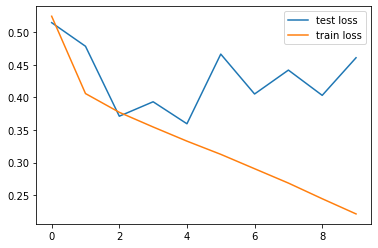

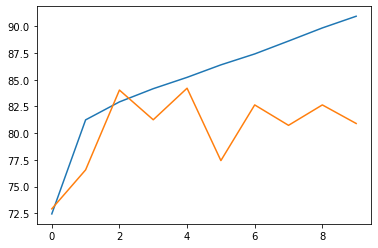

In [54]:

def calculate_accuracy(y_true, y_pred, is_training=False):
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        y_true = y_true.argmax(dim=1)
   
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
   
    epsilon = 1e-7
   
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
   
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    #accuracy = torch.sum(y_true == y_pred) / len(y_pred)
    return accuracy


# prints portion of the review (20-30 first words), with the sub-scores each work obtained
# prints also the final scores, the softmaxed prediction values and the true label values

def print_review(rev_text, sbs1, sbs2, lbl1, lbl2):
    pass 
    # implement

# select model to use

if run_recurrent:
    if use_RNN:
        model = ExRNN(input_size, output_size, hidden_size)
    else:
        model = ExGRU(input_size, output_size, hidden_size)
else:
    if atten_size > 0:
        model = ExRestSelfAtten(input_size, output_size, hidden_size)
    else:
        model = ExMLP(input_size, output_size, hidden_size)

print("Using model: " + model.name())

if reload_model:
    print("Reloading model")
    model.load_state_dict(torch.load(model.name() + ".pth"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)





train_loss = 1.0
test_loss = 1.0
test_losses,train_losses=[],[]
train_acc,test_acc=[],[]

# training steps in which a test step is executed every test_interval

for epoch in range(num_epochs):
    test_index =0
    train_index = 0
    acc_index = 0   
    acc_t_index=0
    test_loss_,train_loss_=0,0
    test_accuracy,train_accuracy=0,0
    itr = 0 # iteration counter within each epoch

    for labels, reviews, reviews_text in train_dataset:   # getting training batches

        itr = itr + 1

        if (itr + 1) % test_interval == 0:
            test_iter = True
            labels, reviews, reviews_text = next(iter(test_dataset)) # get a test batch 
        else:
            test_iter = False

        # Recurrent nets (RNN/GRU)

        if run_recurrent:
            hidden_state = model.init_hidden(int(labels.shape[0]))

            for i in range(num_words):
                output, hidden_state = model(reviews[:,i,:], hidden_state)  # HIDE

        else:  

        # Token-wise networks (MLP / MLP + Atten.) 
        
            sub_score = []
            if atten_size > 0:  
                # MLP + atten
                sub_score, atten_weights = model(reviews)
            else:               
                # MLP
                sub_score = model(reviews)

            output = torch.mean(sub_score, 1)
            
        # cross-entropy loss
        
        if test_iter:
          acc_t_index += 1
          test_accuracy+= calculate_accuracy(labels, torch.softmax(output,1))
        else:
          acc_index += 1
          train_accuracy+= calculate_accuracy(labels, torch.softmax(output,1))
        loss = criterion(output, labels)

        # optimize in training iterations

        if not test_iter:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # averaged losses
        if test_iter:
            test_loss = 0.8 * float(loss.detach()) + 0.2 * test_loss
            test_index += 1
            test_loss_+=test_loss
        else:
            train_loss = 0.9 * float(loss.detach()) + 0.1 * train_loss
            train_loss_+=train_loss
            train_index += 1

        if test_iter:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{itr + 1}/{len(train_dataset)}], "
                f"Train Loss: {train_loss:.4f}, "
                f"Test Loss: {test_loss:.4f}"
            )

            if not run_recurrent:
                nump_subs = sub_score.detach().numpy()
                labels = labels.detach().numpy()
                print_review(reviews_text[0], nump_subs[0,:,0], nump_subs[0,:,1], labels[0,0], labels[0,1])

            # saving the model
            torch.save(model, model.name() + ".pth")
    train_acc.append(100*train_accuracy/acc_index)
    test_acc.append(100*test_accuracy/acc_t_index)
    print(train_acc)
    print(test_acc)
    test_losses.append(test_loss_/test_index)
    train_losses.append(train_loss_/train_index)
plt.figure()
plt.plot(np.array([range(num_epochs)]).reshape(-1,),np.array(test_losses).reshape(-1,))
plt.plot(np.array([range(num_epochs)]).reshape(-1,),np.array(train_losses).reshape(-1,))
plt.legend(['test loss','train loss'])
plt.show()
plt.figure()
plt.plot(np.array([range(num_epochs)]).reshape(-1,),np.array(train_acc).reshape(-1,))
plt.plot(np.array([range(num_epochs)]).reshape(-1,),np.array(test_acc).reshape(-1,))
plt.show()